# Imports

In [1]:
import sys 
import os
sys.path.append(os.path.join(os.getcwd(), '../Code/'))
from Dataset import *

In [2]:
import tensorflow as tf

In [3]:
from keras.models import  Model
from keras.applications.vgg16 import VGG16
from keras.layers import Input , Flatten, Dense, Reshape, Lambda
from keras.layers.convolutional import Conv2D

Using TensorFlow backend.


In [4]:
from PIL import Image

# Load data

In [5]:
# Load dataset
training = Dataset('../Data/NYU_Silberman_100.mat')
testing = Dataset('../Data/NYU_Silberman_101_120.mat')

# Loss function

In [6]:
def mean_dot_product(y_true, y_pred):
    dot = tf.einsum('ijkl,ijkl->ijk',tf.nn.l2_normalize(y_true,3),tf.nn.l2_normalize(y_pred,3))
    n = tf.cast(tf.count_nonzero(dot),tf.float32)
    mean = tf.reduce_sum(dot) / n
    return -1 * mean

# VGG16 Model

In [7]:
def vgg16_model():
    # create model
    input_tensor = Input(shape=(240, 320, 3)) 
    base_model = VGG16(input_tensor=input_tensor,weights='imagenet', include_top=False)
    x = base_model.output
    x = Flatten()(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(80*60*3, activation='relu', name='fc2')(x)
    x = Reshape((60,80,3))(x)
    pred = Lambda(lambda x: tf.image.resize_bilinear(x , [240,320]) )(x)
    model = Model(inputs=base_model.input, outputs=pred)
    # Compile model
    model.compile(loss= 'mean_absolute_error', optimizer='sgd')
    return model

# Training

In [8]:
model = vgg16_model()

In [24]:
for epoch in range(10):
    print('My Epoch', epoch)
    imgs , norms , masks = training.get_batch(1000, 320, 240)
    x = imgs
    y = np.multiply(masks,norms)
    model.fit(x, y, batch_size=1, epochs=2)

My Epoch 0
Epoch 1/2
1000/1000 [==============================] - 121s - loss: 0.3477   
Epoch 2/2
1000/1000 [==============================] - 121s - loss: 0.3432   
My Epoch 1
Epoch 1/2
1000/1000 [==============================] - 121s - loss: 0.3400   
Epoch 2/2
1000/1000 [==============================] - 121s - loss: 0.3382   
My Epoch 2
Epoch 1/2
1000/1000 [==============================] - 121s - loss: 0.3392   
Epoch 2/2
1000/1000 [==============================] - 121s - loss: 0.3376   
My Epoch 3
Epoch 1/2
1000/1000 [==============================] - 121s - loss: 0.3362   
Epoch 2/2
1000/1000 [==============================] - 121s - loss: 0.3347   
My Epoch 4
Epoch 1/2
1000/1000 [==============================] - 121s - loss: 0.3339   
Epoch 2/2
1000/1000 [==============================] - 121s - loss: 0.3329   
My Epoch 5
Epoch 1/2
1000/1000 [==============================] - 121s - loss: 0.3348   
Epoch 2/2
1000/1000 [==============================] - 121s - loss: 0.3340  

# Prediction

In [10]:
imgs , norms , masks = testing.get_batch(10, 320, 240)

In [35]:
pred = model.predict(imgs,batch_size=1)

In [51]:
i = 7

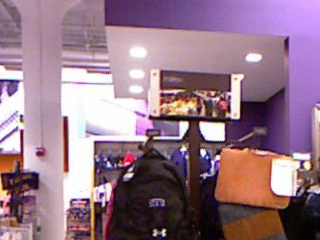

In [52]:
Image.fromarray(imgs[i,:,:,:].astype(np.uint8))

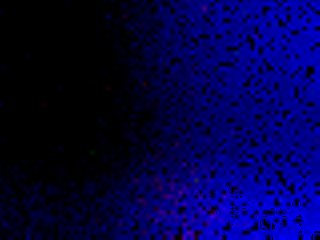

In [53]:
Image.fromarray((np.abs(pred[i,:,:,:])*255).astype(np.uint8))

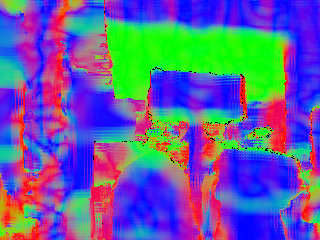

In [54]:
Image.fromarray((np.abs(norms[i,:,:,:])*255).astype(np.uint8))

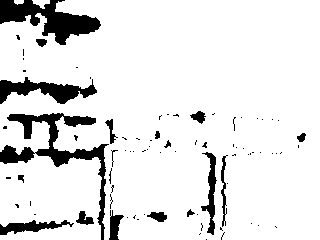

In [95]:
Image.fromarray(masks[i,:,:,:].reshape(240,320)*255)

In [45]:
model.save('../Data/BaselineV1.h5')